In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import sys
sys.path.append("..")
import time
import warnings
from pathlib import Path
from copy import copy

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch

from falkon.kernels import GaussianKernel
from falkon import FalkonOptions
from nyskoop.data.lorenz import Lorenz63
from experiment_helpers import *

In [141]:
set_matplotlib_rc(18, 20, 22)

In [142]:
def gen_l63_fulldata(n_train: int, n_test: int, num_test_sets: int, max_q: int, **kwargs):
    ics = np.array([1, 1, 1])
    lorenz63_dset = Lorenz63(ics[0], ics[1], ics[2], sigma=10, rho=28, beta=8/3, **kwargs)
    full_data = lorenz63_dset.solve(n_train + num_test_sets * n_test + max_q * (num_test_sets + 1))
    full_data = torch.from_numpy(full_data)
    return full_data

In [143]:
fig_path = Path("outputs/timings")
fig_path.mkdir(exist_ok=True, parents=True)

**Generate the whole dataset. Max 10k training points**

In [179]:
q = 40  # How many steps-ahead for predictions
num_test_sets = 5
n_test = 10_000
full_data = gen_l63_fulldata(
    100_000, n_test, num_test_sets, max_q=q, dt=0.01, burnin=5, l63_version='normal'
)

**Helper functions to run the experiments**

In [299]:
def gen_data_get_error(n_train, n_reps, dtype, **model_hps):
    X_train, Y_train, all_test_sets = gen_lagged(
        full_data, n_train, n_test, num_test_sets, q, dtype=dtype
    )
    errs, times = [], []
    for i in range(n_reps):
        t_start = time.time()
        if "M" in model_hps:
            model_hps["M"] = int(5 * np.sqrt(n_train))
        if "penalty" in model_hps:
            model_hps["penalty"] = 1 / np.sqrt(n)
        est = train_est(X_train, Y_train, **model_hps)
        t_end = time.time()
        times.append(t_end - t_start)
        err = nrmse(est, all_test_sets, variable='all')[0].mean()
        errs.append(err.item())
    return (
        np.median(errs),
        np.percentile(errs, 90),
        np.percentile(errs, 10),
        np.min(times)
   )

In [146]:
def hp_search_inner(hp_dict, fn, out_df: pd.DataFrame, pbar: tqdm, **kwargs):
    new_dict = copy(hp_dict)
    
    final_hp_key, hp_list = None, []
    for hp_key in list(new_dict.keys()):
        hp_list = new_dict.pop(hp_key)
        # Allow to specify different HP values for different 'kind' of algorithms
        if isinstance(hp_list, dict):
            hp_list = hp_list.get(kwargs['kind'], [])
        if len(hp_list) > 0:
            final_hp_key = hp_key
            break
    
    if len(new_dict) == 0 and final_hp_key is None:  # base case??
        err, err_high, err_low, t_elapsed = fn(**kwargs)
        kwargs["err"] = err
        kwargs["err_high"] = err_high
        kwargs["err_low"] = err_low
        kwargs["time"] = t_elapsed
        pbar.update(1)
        return pd.DataFrame.from_dict([kwargs])
    
    hp_dfs = []
    for hp_val in hp_list:
        kwargs[final_hp_key] = hp_val
        try:
            hp_dfs.append(hp_search_inner(new_dict, fn, out_df, pbar, **kwargs))
        except Exception as e:
            warnings.warn(f"{kwargs} failed.")
            raise
    return pd.concat([out_df] + hp_dfs)

def hp_search(hp_dict, fn, out_df, **kwargs):
    np.random.seed(42)
    torch.manual_seed(42)
    # Calculate total iterations taking into account the special dict case
    total = 0
    for algo_kind in hp_dict["kind"]:
        subtotal = 1
        for k, v, in hp_dict.items():
            if k == "kind": continue
            if isinstance(v, dict):
                subtotal *= len(v.get(algo_kind, [1]))
            elif isinstance(v, list) or isinstance(v, tuple):
                subtotal *= len(v)
        total += subtotal
    with tqdm(desc='HP Search', total=total, mininterval=1.0) as pbar:
        return hp_search_inner(hp_dict, fn, out_df, pbar, **kwargs)

**Define hyperparameters**

The `kind` key defines which estimators will run.

The other keys are hyperparameters for either the estimators or the data generation.

Remember to set the **exp_name** variable appropriately!

In [300]:
pcr_hps_n = {
    "kind": ["pcr", "rrr", "krr"],#["full_rrr", "rrr", "full_pcr", "pcr", ],
    "M": {"pcr": [250], "rrr": [250], "krr": [250]},
    "kernel": [GaussianKernel(3.5, opt=FalkonOptions(use_cpu=True))],
    "num_components": {
        "pcr": [25],
        "full_rrr": [25],
        "rrr": [25],
        "full_pcr": [25],
    },
    # 'n_train' is the x-axis for this experiment: time/error as n_train increases.
    "n_train": {
        "full_rrr": np.logspace(2, 4, 10, dtype=int)[:-2],  # takes too long if we go up to 10**4
        "rrr": np.logspace(2, 4.8, 20, dtype=int),
        "full_pcr": np.logspace(2, 4, 10, dtype=int),
        "pcr": np.logspace(2, 4.8, 20, dtype=int),
        "krr": np.logspace(2, 4.8, 20, dtype=int),
    },
    "n_reps": {
        "full_rrr": [2],  # only 2 reps since there is no variability in error (only in timings)
        "full_pcr": [2],
        "rrr": [20],
        "pcr": [20],
        "krr": [20]
    },
    "dtype": [torch.float32],
    "penalty": {"rrr": [1e-4], "full_rrr": [1e-4], "krr": [1e-2]},
}
exp_name = "l63_varym_varyn_5sqrtn"
pcr_n_df_path = Path(f"outputs/timings/{exp_name}.csv")
pcr_n_df_path.parent.mkdir(parents=True, exist_ok=True)

**Run experiment with increasing training set size**

In [301]:
pcr_n_df = hp_search(
    pcr_hps_n, 
    gen_data_get_error,
    pd.DataFrame()
)
pcr_n_df["sigma"] = pcr_n_df["kernel"].apply(lambda r: r.sigma.item())
pcr_n_df = pcr_n_df.drop(columns=["kernel"])
pcr_n_df.to_csv(pcr_n_df_path, index=False)
print(f"Saved experiment statistics at {pcr_n_df_path}")

HP Search:  33%|██████████▋                     | 20/60 [01:32<09:23, 14.09s/it]/tmp/ipykernel_2868/1204261774.py:29: UserWarning: {'kind': 'rrr', 'M': 250, 'kernel': GaussianKernel(sigma=Parameter containing:
tensor([3.5000], dtype=torch.float64)), 'num_components': 25, 'n_train': 100, 'n_reps': 20, 'dtype': torch.float32, 'penalty': 0.0001} failed.
  warnings.warn(f"{kwargs} failed.")
/tmp/ipykernel_2868/1204261774.py:29: UserWarning: {'kind': 'rrr', 'M': 250, 'kernel': GaussianKernel(sigma=Parameter containing:
tensor([3.5000], dtype=torch.float64)), 'num_components': 25, 'n_train': 100, 'n_reps': 20, 'dtype': torch.float32} failed.
  warnings.warn(f"{kwargs} failed.")
/tmp/ipykernel_2868/1204261774.py:29: UserWarning: {'kind': 'rrr', 'M': 250, 'kernel': GaussianKernel(sigma=Parameter containing:
tensor([3.5000], dtype=torch.float64)), 'num_components': 25, 'n_train': 100, 'n_reps': 20} failed.
  warnings.warn(f"{kwargs} failed.")
/tmp/ipykernel_2868/1204261774.py:29: UserWarning: {

NameError: name 'n' is not defined

Plotting results from experiment at outputs/timings/l63_varym_varyn_5sqrtn.csv


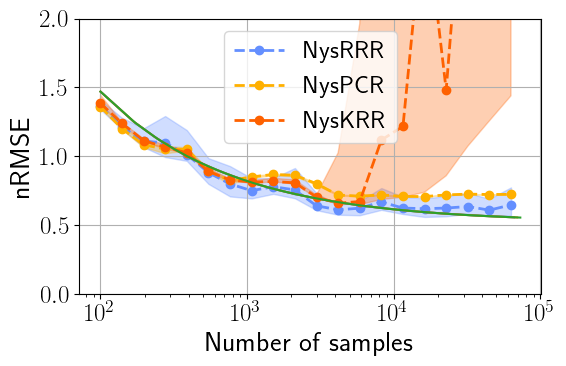

In [296]:
print(f"Plotting results from experiment at {pcr_n_df_path}")
plot_time = False
plot_fit = True
if plot_time:
    fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
else:
    fig, ax = plt.subplots(ncols=1, figsize=(6, 4))
    ax = [ax]
models = [
#     ("full_rrr", "FullRRR", IBM_COLORS[3], "-", f"outputs/timings/l63_varyn_m250_all.csv"),
    ("rrr", "NysRRR", IBM_COLORS[1], "--",      f"outputs/timings/l63_varym_varyn_5sqrtn.csv"),
#     ("full_pcr", "FullPCR", IBM_COLORS[0], "-", f"outputs/timings/l63_varyn_m250_all.csv"),
    ("pcr", "NysPCR", IBM_COLORS[2], "--",      f"outputs/timings/l63_varym_varyn_5sqrtn.csv"),
    ("krr", "NysKRR", IBM_COLORS[0], "--",      f"outputs/timings/l63_varym_varyn_5sqrtn.csv"),
]

for kind, lbl, c, ls, path in models:
    df = pd.read_csv(path)
    # Error
    ax[0].plot(
        df[df["kind"] == kind]["n_train"],
        df[df["kind"] == kind]["err"], label=lbl, 
        c=c, marker='o', lw=2, linestyle=ls
    )
    ax[0].fill_between(
        df[df["kind"] == kind]["n_train"],
        df[df["kind"] == kind]["err_low"],
        df[df["kind"] == kind]["err_high"],
        color=c, alpha=0.3,
    )
    if plot_fit:
        fitx = np.linspace(100, ax[0].get_xlim()[1], 1000)
#         coefs = np.polyfit(df[df["kind"] == kind]["err"], 1 / np.sqrt(df[df["kind"] == kind]["n_train"]), deg=1)
#         print(df[df["kind"] == kind]["err"])
#         print(1 / np.sqrt(df[df["kind"] == kind]["n_train"]))
#         print(coefs)
        ax[0].plot(fitx, 9.5 / np.sqrt(fitx) + 0.52)
    if plot_time:
        ax[1].plot(
            df[df["kind"] == kind]["n_train"],
            df[df["kind"] == kind]["time"], 
            c=c, marker='o', lw=2, linestyle=ls
        )

ax[0].set_xlabel('Number of samples')
ax[0].set_ylabel("nRMSE")
ax[0].set_xscale('log')
# ax[0].set_xlim(100, 10000)

if plot_time:
    ax[1].set_xlabel('Number of samples')
    ax[1].set_ylabel('Time (s)')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(100, 10000)
    ax[1].set_yticks([1e-2, 1e-1, 1, 1e1, 1e2])

ax[0].set_ylim([0, 2.0])

ax[0].grid()
# fig.legend(ncols=len(models), loc='upper center', bbox_to_anchor=(0.5, 1))
ax[0].legend(loc='best')
fig.tight_layout()
# fig.subplots_adjust(top=0.88)
fig.savefig(pcr_n_df_path.with_suffix('.png'), dpi=300)

In [231]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
y = 1 / np.sqrt(x) + np.random.randn(len(x)) * 0.01
coefs = np.polyfit(y, 1 / np.sqrt(x), deg=1)
print(f"{coefs=}")

coefs=array([0.98773111, 0.0083463 ])


In [225]:
# y ~ a / sqrt(x) + b
# y ~ c * x**2 + d * x + e

# y - b ~ a / sqrt(x)
# (y - b)**2 ~ a**2 / x
# x ~ [a / (y-b)]**2 = a ** 2 / (y**2 - 2by + b ** 2) = (a / y) ** 2
# sqrt(x) ~ a / (y - b)

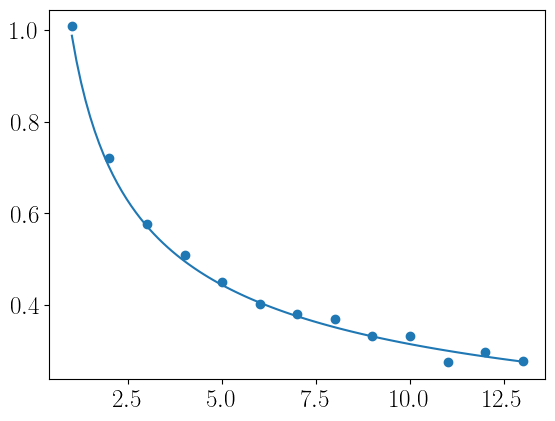

In [226]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(np.linspace(1, 13, 100), (coefs[0] / np.sqrt(np.linspace(1, 13, 100)) + coefs[1]))

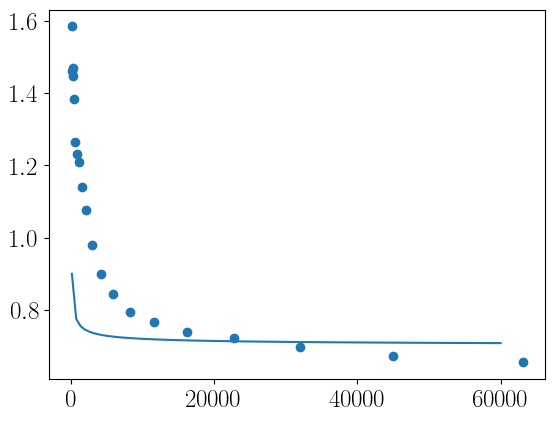

In [276]:
fitx = np.linspace(100, 60_000, 100)
coefs = np.polyfit(
    df[df["kind"] == kind]["err"], 
    1 / np.sqrt(df[df["kind"] == kind]["n_train"]),
    deg=1
)
# print(df[df["kind"] == kind]["err"])
# print(1 / np.sqrt(df[df["kind"] == kind]["n_train"]))
# print(coefs)
fig, ax = plt.subplots()
ax.scatter(
    df[df["kind"] == kind]["n_train"], 
    df[df["kind"] == kind]["err"]
)
ax.plot(fitx, 2/(fitx ** (1/2))+0.7)#(13 / (1 * np.sqrt(fitx))) + 0.7)

In [277]:
coefs

array([ 0.08593261, -0.05943817])

In [281]:
0.08 / np.sqrt(100)

0.008

In [282]:
1 / np.sqrt(df[df["kind"] == kind]["n_train"])

40    0.100000
41    0.084515
42    0.071247
43    0.060193
44    0.050767
45    0.042835
46    0.036155
47    0.030500
48    0.025743
49    0.021724
50    0.018331
51    0.015471
52    0.013055
53    0.011018
54    0.009299
55    0.007848
56    0.006623
57    0.005589
58    0.004717
59    0.003981
Name: n_train, dtype: float64